# PRESIDENTIAL PREDICTION

## Importing libraries

In [ ]:
# importing the libraries that we will nned
import gensim
from nltk.stem import WordNetLemmatizer
import nltk
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import nltk
nltk.download('stopwords')

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

## Loading dataset

In [ ]:
# Load dataframe
def load_csv(filepath):
    df = pd.read_csv(filepath)
    return df

In [ ]:
# loading dataframe
filepath = "cleaned_df_amos.csv"

df = load_csv(filepath)

## Previewing dataset

In [ ]:
# function to preview the dataframe preview dataframe
def preview_df(df):
    head = df.head()
    tail = df.tail()
    random_sample = df.sample(30)
    rows, columns = df.shape

    return head, tail, random_sample, print(f"THe dataframe has {rows} rows and {columns} columns")


In [ ]:
# preview shape of datframe
rows, columns = df.shape

# print
print(f"THe dataframe has {rows} rows and {columns} columns")

THe dataframe has 405650 rows and 6 columns


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405650 entries, 0 to 405649
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0.1   405650 non-null  int64 
 1   Unnamed: 0     405650 non-null  object
 2   tweet_id       405650 non-null  object
 3   time           405650 non-null  object
 4   tweet          405649 non-null  object
 5   retweet_count  405650 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 18.6+ MB


In [ ]:
# previewing the dataframe
preview_df(df)

THe dataframe has 405650 rows and 6 columns


(   Unnamed: 0.1 Unnamed: 0             tweet_id                 time  \
 0             1          1  1543382261164302337  2022-07-02 23:53:00   
 1             2          2  1543379565648773121  2022-07-02 23:42:17   
 2             5          5  1543377927773081603  2022-07-02 23:35:47   
 3             6          6  1543377130201006084  2022-07-02 23:32:37   
 4             7          7  1543377046105120770  2022-07-02 23:32:17   
 
                                                tweet  retweet_count  
 0  @kilundeezy Hii ndio ubaya ya kukosa degreüòÇüòÇüòÇ....              0  
 1  Mathira MP Rigathi Gachagua says Azimio la Umo...              0  
 2  @LakesideBy @DavidNdii @SilviaWangeci2 @Nation...              0  
 3  @alvinsabuya @ahmednasirlaw Uhuru is the Azimi...              0  
 4  @PWamugunda @DavidNdii Hivyo ndivyo naingia Az...              0  ,
         Unnamed: 0.1 Unnamed: 0             tweet_id                 time  \
 405645       1967556     342927  153670016073

## Data preprocessing

### Missing Values

In [ ]:
# checking for missing values

# checking if there are any missing values in the dataset
df.isnull().sum()

Unnamed: 0.1     0
Unnamed: 0       0
tweet_id         0
time             0
tweet            1
retweet_count    0
dtype: int64

There was one missing value in the cleaned tweet

In [ ]:
# finding the percentage of missing values for each column
percent_missing = round(df.isnull().sum() * 100 / len(df),2)
percent_missing

Unnamed: 0.1     0.0
Unnamed: 0       0.0
tweet_id         0.0
time             0.0
tweet            0.0
retweet_count    0.0
dtype: float64

In [ ]:
# finding the percentage of missing values for the entire dataset
percentage_missing = round(df.isnull().sum().sum() * 100 / len(df),2)
percentage_missing

0.0

Missing values made up 0.01% of dataframe hence shall be dropped

In [ ]:
# dropping the missing values in tweet_id
df = df.dropna()

In [ ]:
# checking to see if the missing values have been imputed
df.isnull().sum()

Unnamed: 0.1     0
Unnamed: 0       0
tweet_id         0
time             0
tweet            0
retweet_count    0
dtype: int64

All null values  have been successfully drop

### Pre_processing tweets

Here we are processing the tweets to remove the  special characters, convert texts to lower case, remove unnecessary links and images this with an aim to make the tweets more easy to analyse 

In [ ]:
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~‚Ä¢@'         # define a string of punctuation symbols

# Functions to clean tweets
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('üìù ‚Ä¶', '', tweet)
    return tweet

def tokenize_tweets(df):
    """Main function to read in and return cleaned and preprocessed dataframe.
    This can be used in Jupyter notebooks by importing this module and calling the tokenize_tweets() function
    Args:
        df = data frame object to apply cleaning to
    Returns:
        pandas data frame with cleaned tokens
    """

    df['tokens'] = df.tweet.apply(preprocess_tweet)
    num_tweets = len(df)
    print('Complete. Number of Tweets that have been cleaned and tokenized : {}'.format(num_tweets))
    return df

In [ ]:
# applying preprocessings to the tweet
df['tweet_clean'] = df['tweet'].apply(preprocess_tweet)

In [ ]:
# sampling five tweets to see the 
df.sample(5)

Unnamed: 0.1 Unnamed: 0             tweet_id                 time  \
144702        136768      20728  1542241352045699073  2022-06-29 20:19:26   
304072        136926     162170  1537520802651942912  2022-06-14 10:53:03   
272758        104342     129570  1538494752894623745  2022-06-14 10:53:03   
60273          39689      39688  1542551908421976070  2022-06-30 16:53:28   
197877        191597       7962  1542537131058515968  2022-06-30 15:54:45   

                                                    tweet  retweet_count  \
144702  After losing Narok County to UDA, RAILA ODINGA...              1   
304072                      @ReallyAmerican1 And the 5th!              0   
272758              Sticky like the 5th best song on here              0   
60273   @WilliamsRuto @SakajaJohnson CUE imefanya ile ...              0   
197877  Ukiskiza hao wafu wa wajackoyah utajua haendi ...              1   

                                              tweet_clean  
144702  lose narok county uda raila odinga lose kajiad...  
304072                                                     
272758                              sticky like best song  
60273   cue imefanya ile kitu tena mkuu yaani ndani hi...  
197877    ukiskiza hao wafu wajackoyah utajua haendi maha

### Data validity

Here entails converting the various attributes to appropiate data types

In [ ]:
# changing the datatype of retweet_count and time to their respective datatypes
df['retweet_count'] = df['retweet_count'].astype('int')
df['time'] = pd.to_datetime(df['time'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 405649 entries, 0 to 405649
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Unnamed: 0.1   405649 non-null  int64         
 1   Unnamed: 0     405649 non-null  object        
 2   tweet_id       405649 non-null  object        
 3   time           405649 non-null  datetime64[ns]
 4   tweet          405649 non-null  object        
 5   retweet_count  405649 non-null  int32         
 6   tweet_clean    405649 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 23.2+ MB


All columns now have appropiate datatypes

### checking duplicates

In [ ]:
# checking if we have duplicates in our 'tweet_id' column since it is out unique identifier
df.duplicated().sum()


0

no duplicate records

In [ ]:
# checking for duplicate cleaned tweets
duplicate_tweets  = df['tweet_clean'].duplicated().sum()

# print duplicate tweet numbers
print(f'''
There are {duplicate_tweets} duplicate tweets in the dataset after cleaning. 
They shall be dropped maintaining only the last tweet
''')


There are 52210 duplicate tweets in the dataset after cleaning. 
They shall be dropped maintaining only the last tweet



In [ ]:
# dropping the duplicates in the tweet_clean column keeping last
df.drop_duplicates(subset=['tweet_clean'], keep='last', inplace=True)

In [ ]:
# confirm for any remaining duplicate records remaining
duplicate_tweets  = df['tweet_clean'].duplicated().sum()

# print duplicate tweet numbers
print(f'''
There are {duplicate_tweets} duplicate tweets in the dataset after cleaning. 
''')


There are 0 duplicate tweets in the dataset after cleaning. 



In [ ]:
# shape of dataframe after dealing with duplicate tweets and missing values
rows1, columns1 = df.shape

# printing
print(f'''
The dataframe has {rows1} remaining records and {columns1} remaining columns. 
There has been a lose of {((rows-rows1)/ rows) * 100}% of all records
''')


The dataframe has 353439 remaining records and 7 remaining columns. 
There has been a lose of 12.870947861456921% of all records



## Feature engineering

Here we are going to create new columns containing the subjectivity and polarity of the tweet

In [ ]:
# Creating a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Creating a function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# Creating two additional columns to check the Subjectivity and Polarity
df['Subjectivity'] = df['tweet_clean'].apply(getSubjectivity)
df['Polarity'] = df['tweet_clean'].apply(getPolarity)

# Previewing random samples of five records
df.sample(5)

Unnamed: 0.1 Unnamed: 0             tweet_id                time  \
389555       1911533     286229  1537006905712947200 2022-06-20 17:47:16   
264965         96026     121252  1538749302335414274 2022-06-14 10:53:03   
286662        119054     144290  1537952409502093314 2022-06-14 10:53:03   
151009        143287      27247  1542047027303006208 2022-06-29 07:27:15   
360579       1881717     255963  1538596832892313601 2022-06-20 17:47:16   

                                                    tweet  retweet_count  \
389555  Chaos at Raila Odinga rally in Machakos - See ...              0   
264965  After IND vs SA 5th T20I gets washed out, Aaka...              0   
286662  The Knights responded to Clinton's rally by ma...              0   
151009  RAILA ALINYIMA KALONZO CHANCE YA KUONGEA KWA M...              0   
360579  @normpkk @RailaOdinga Watoto wa Raila @RailaOd...              0   

                                              tweet_clean  Subjectivity  \
389555  chaos raila odinga rally machakos security qui...      0.500000   
264965          ind get wash aakash chopra tweet go viral      0.000000   
286662  knight respond clinton rally make home half ma...      0.260317   
151009  raila alinyima kalonzo chance kuongea kwa mazi...      0.000000   
360579                   watoto raila bado hawajatahiriwa      0.000000   

        Polarity  
389555  0.333333  
264965  0.000000  
286662 -0.212698  
151009  0.000000  
360579  0.000000

In [ ]:
# Aspirant finder to find the various aspirants participating in the 2022 Kenyan general elections
the_list = ['wajackoyah', 'raila',  'ruto', 'deputy', 'baba']

def aspirant_finder(string):
    term_return = 'None'
    for term in the_list:
        if term in string:
            term_return = term
    return term_return

# Coalition finder: Find the various coalitions in 2022 kenya general election
the_list1 = ['kwanza', 'azimio',  'root', 'kwisha', 'assimio', 'uda', 'anc', 'odm', 'ford kenya', 'wiper', 'maendeleo', 'dap', 'chama cha kazi', 'hustler nation']

def coalition_finder(string):
    term_return = 'None'
    for term in the_list1:
        if term in string:
            term_return = term
    return term_return


In [ ]:
# applying the aspirant finder function
df['presidential_aspirant'] = df['tweet_clean'].apply(aspirant_finder)

# Replacing the various names used to refer to top preseidential contenders with their oficial names
df =df.replace({'presidential_aspirant' : { 'deputy' : 'Dr. William Samoei Ruto', 'baba' : 'Raila Amollo Odinga', 'ruto' : 'Dr. William Samoei Ruto', 'raila': 'Raila Amollo Odinga',  'wajackoyah': 'Prof. George Luchiri Wajackoyah'}})

# Sampling 10 records
df.sample(10)

Unnamed: 0.1 Unnamed: 0             tweet_id                time  \
210686          8738      19082  1540000661391216641 2022-06-23 15:55:44   
301388        134212     159454  1537563774516875265 2022-06-14 10:53:03   
126151        117606       1567  1543291769756024833 2022-07-02 17:53:25   
395518       1925078     300439  1539922075233681410 2022-06-23 10:43:27   
90256          75474      75473  1541552073824665601 2022-06-27 22:40:29   
272645        104219     129447  1538498913409601537 2022-06-14 10:53:03   
313065        146181     171431  1537266563614654465 2022-06-14 10:53:03   
158044        150539      34499  1541843467218944000 2022-06-28 17:58:23   
79923          62593      62592  1542018428369764352 2022-06-29 05:33:37   
366444       1887710     262063  1538383287126728706 2022-06-20 17:47:16   

                                                    tweet  retweet_count  \
210686  Raira and Ruto may be the most likely but in t...              0   
301388                   beat #ELDENRING for the 5th time              0   
126151  @JunetMohamed @RailaOdinga @HassanAliJoho @ore...              0   
395518  Ladies and gentlemen, this is what Kenya Kwanz...              0   
90256   @kuriasolomonK Twitter if for those wise  Ruto...              0   
272645  #INDvSA   5th T20I: As India look to secure a ...              0   
313065  My husband has deeply potent art: Saturn ruled...              0   
158044  @KbnJ_ @WilsonKiplanga4 @RailaOdinga You think...              0   
79923   @MakauWaMuli What is so difficulty for you to ...              0   
366444  Pure love for Baba @RailaOdinga . Meru 91.3%  ...              0   

                                              tweet_clean  Subjectivity  \
210686                  raira ruto likely hand kenya doom      1.000000   
301388                                          beat time      0.000000   
126151                           campaign strongholds add      0.000000   
395518       ladies gentlemen kenya kwanza lead education      0.000000   
90256   twitter wise ruto hawezi shinda huku like suppose      0.900000   
272645  india look secure memorable come series win sp...      0.511111   
313065  husband deeply potent art saturn rule venus ta...      0.500000   
158044  think gullible follow mzee time better kunguni...      0.333333   
79923   difficulty differentiate government ruto justi...      0.000000   
366444                    pure love baba meru tuko azimio      0.550000   

        Polarity    presidential_aspirant  
210686  0.000000  Dr. William Samoei Ruto  
301388  0.000000                     None  
126151  0.000000                     None  
395518  0.000000                     None  
90256   0.700000  Dr. William Samoei Ruto  
272645  0.211616                     None  
313065  0.500000                     None  
158044  0.183333                     None  
79923   0.000000  Dr. William Samoei Ruto  
366444  0.357143      Raila Amollo Odinga

In [ ]:
# applying the coalition finder function
df['coalition'] = df['tweet_clean'].apply(coalition_finder)

# Renaming the various party mentions and the various terms used to refer to coalitions and 
# partys by the general pulic with the official names of the colaitions they belong tu
df =df.replace({'coalition' : { 'kwanza': 'Kenya Kwanza', 'root': 'Roots Party', 'kwisha': 'Kenya Kwanza', 'azimio': 'azimio OKA alliance', 'assimio':'azimio OKA alliance', 'uda': 'Kenya Kwanza', 'hustler nation': 'Kenya Kwanza', 'odm': 'azimio OKA alliance'}})

# Sampling 10 records
df.sample(10)

Unnamed: 0.1 Unnamed: 0             tweet_id                time  \
229322         53386      78280  1537361710134214656 2022-06-16 09:09:29   
146364        138494      22454  1542169933844471808 2022-06-29 15:35:39   
270298        101696     126924  1538566451165945863 2022-06-14 10:53:03   
59998          39388      39387  1542553668578426888 2022-06-30 17:00:28   
145925        138042      22002  1542189014937124864 2022-06-29 16:51:28   
302941        135779     161023  1537535067630747648 2022-06-14 10:53:03   
72066          53119      53118  1542203464369020928 2022-06-29 17:48:53   
240654         70505      95716  1539560368363773959 2022-06-14 10:53:03   
168733        161647      45606  1541432109830651905 2022-06-27 14:43:48   
212821         14219      26782  1539898378166878208 2022-06-23 09:09:17   

                                                    tweet  retweet_count  \
229322  @Hon_wajackoyah_ I think these are more practi...              0   
146364  @MRSMuruguK @RailaOdinga @Ammar_Kassim8 Ruto t...              0   
270298  @yeatesy46 @ManUtd @Mr_CeoTon Pau Torres is th...              0   
59998   Siasa za Kenya wakati huu wa kampeni za uchagu...              0   
145925  @Moha001_Onyango @TheODMparty Uko sure uko rea...              0   
302941  @JoJoFromJerz When you plead the 5th, you‚Äôre s...              0   
72066   @Felix_Mwe @Kadasia99 @kamaukinyingi @Dawg_001...              0   
240654  @MollyJongFast I plead the 5th too if I knew t...              0   
168733  @HusseinMohamedg Ndugu Hussein. The voters pre...              3   
212821  @WilliamsRuto Ruto why do you fool kenyans are...              0   

                                              tweet_clean  Subjectivity  \
229322  think practical reasonable apart buy police of...      0.600000   
146364                                         ruto tawee      0.000000   
270298                             pau torres think sales      0.000000   
59998   siasa kenya wakati huu kampeni uchaguzi vyombo...      0.850000   
145925               uko sure uko ready prove raila halal      0.694444   
302941                                   plead say guilty      1.000000   
72066   kikuyus know muthamaki mean matter kalenjin ru...      0.687500   
240654  plead know wasn heart effort prosecute plead c...      0.000000   
168733  ndugu hussein voters present azimio uda ask ca...      0.266667   
212821  ruto fool kenyans deputy president earn salary...      0.000000   

        Polarity    presidential_aspirant     coalition  
229322    0.2000                     None          None  
146364    0.0000  Dr. William Samoei Ruto          None  
270298    0.0000                     None          None  
59998     0.5500                     None           anc  
145925    0.3500      Raila Amollo Odinga          None  
302941   -0.5000                     None          None  
72066    -0.3125  Dr. William Samoei Ruto          None  
240654    0.0000                     None          None  
168733    0.3000      Raila Amollo Odinga  Kenya Kwanza  
212821    0.0000  Dr. William Samoei Ruto          None

## Downloading dataframe

The cleaned and feature engineered dataframe shall be downloaded for the use in our streamlit ui

In [ ]:
from google.colab import files
df.to_csv('elections_df.csv') 
files.download('elections_df.csv')

## Exploratory data analysis

In [ ]:
# Creating copy of cleaned dataframe
df1 = df.copy()

### Word popularity - general

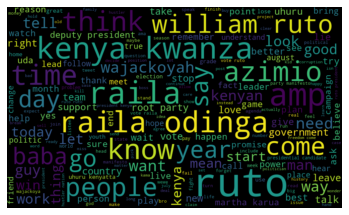

In [ ]:
# Plotting Word Cloud 
allWords = ' '.join([twts for twts in df['tweet_clean']])
wordCloud = WordCloud(width = 1000, height = 600, random_state = 12, max_font_size = 119).generate(allWords)
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()


<AxesSubplot:title={'center':'Bigram disribution for the top 20 words in the Tourism Name'}, xlabel='bigram'>

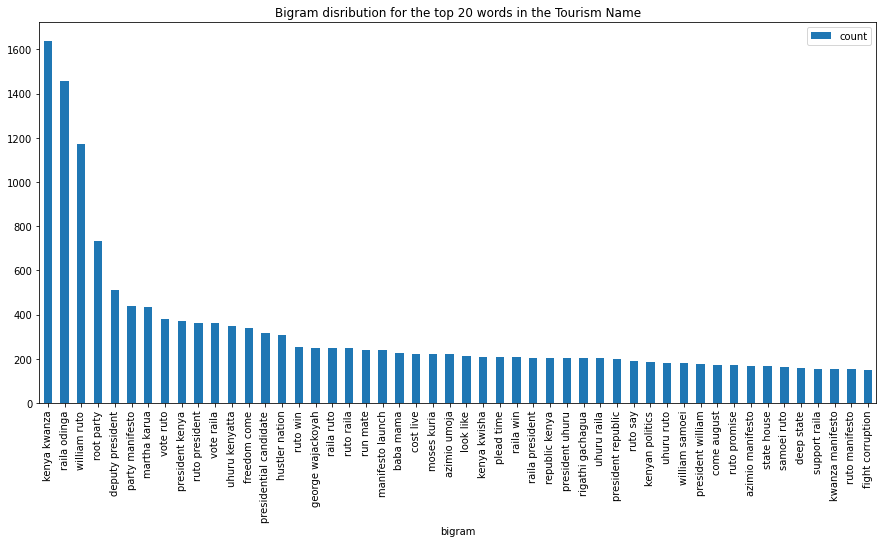

In [ ]:
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df1['tweet_clean'])
total_words = tfidf_matrix.sum(axis=0) 

#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True)
 
#Taking first 20 records
words1 = bigram.head(50)

#Plotting the bigram distribution
words1.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the Tourism Name", figsize = (15,7), )

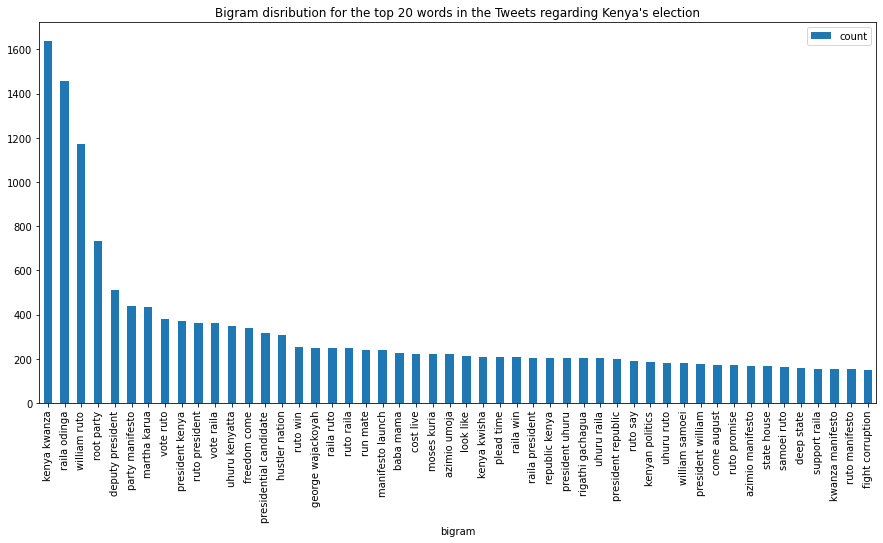

In [ ]:
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df1['tweet_clean'])
total_words = tfidf_matrix.sum(axis=0) 

#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 

#Taking first 20 records
words2 = bigram.head(50)

#Plotting the bigram distribution
fig = words2.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the Tweets regarding Kenya's election", figsize = (15,7), )

### Word popularity - Presidential aspirants

In [ ]:
# Applying aspirant finder function
words1['presidential_aspirant'] = words1['bigram'].apply(aspirant_finder)

In [ ]:
# Replacing the various names used to refer to top preseidential contenders with their oficial names
words_clean =words1.replace({'presidential_aspirant' : { 'deputy' : 'Dr. William Samoei Ruto', 'baba' : 'Raila Amollo Odinga', 'ruto' : 'Dr. William Samoei Ruto', 'raila': 'Raila Amollo Odinga',  'wajackoyah': 'Prof. George Luchiri Wajackoyah'}})

# Dropping the now irrelevant bigram column
words_presidents = words_clean.drop('bigram', axis = 1)

# Group the records based on the presidential aspirants
words_president = words_presidents.groupby('presidential_aspirant',  as_index=False, sort=False).agg({'count': 'sum'})

# Drop records that have no mention of the presidential aspirant
words_president.drop(words_president.loc[words_president['presidential_aspirant']== 'None'].index, inplace=True)

# Get a count of the mentions of the presidential aspirants as a percentage
words_president['count'] = (words_president['count']/ words_president['count'].sum()) * 100
words_president

presidential_aspirant      count
1              Raila Amollo Odinga  39.664946
2          Dr. William Samoei Ruto  56.793755
3  Prof. George Luchiri Wajackoyah   3.541299

### Word popularity - coalitions

In [ ]:
# applying the coalition finder function
words1['coalition'] = words1['bigram'].apply(coalition_finder)

In [ ]:
# Renaming the various party mentions and the various terms used to refer to coalitions and 
# partys by the general pulic with the official names of the colaitions they belong tu
words_clean =words1.replace({'coalition' : { 'kwanza': 'Kenya Kwanza', 'root': 'Roots Party', 'kwisha': 'Kenya Kwanza', 'azimio': 'azimio OKA alliance', 'assimio':'azimio OKA alliance', 'uda': 'Kenya Kwanza', 'hustler nation': 'Kenya Kwanza', 'odm': 'azimio OKA alliance'}})

# Dropping the now irrelevant bigram column
words_partys = words_clean.drop('bigram', axis = 1)

# groupning the records based on coalitions
words_party = words_partys.groupby('coalition',  as_index=False, sort=False).agg({'count': 'sum'})

# Dropping all records without a mention of a qualition in the tweet
words_party.drop(words_party.loc[words_party['coalition']== 'None'].index, inplace=True)

# Finding the mentions per coalition in percentage format
words_party['count'] = (words_party['count']/ words_party['count'].sum()) * 100

# output
words_party

coalition      count
0         Kenya Kwanza  67.237060
2          Roots Party  21.375510
3  azimio OKA alliance  11.387431

In [ ]:
# Creating dataframe subsets with tweets containing information on of the various presidential aspirants

# Dataset containing Ruto's mentions
df_ruto = df1 [df1 ['presidential_aspirant'] == 'Dr. William Samoei Ruto']

# Dataset containing raila's mentions
df_raila = df1 [df1 ['presidential_aspirant'] == 'Raila Amollo Odinga']

# Dataset containing Wajackoyahs mentions
df_wajackoyah = df1 [df1 ['presidential_aspirant'] == 'Prof. George Luchiri Wajackoyah']


### Polarity - assignements

Assigning sentiments as positive negative or neutral

**Note**

Polarity > 0 = Positive sentiment

Polarity < 0 = Negative sentiment

Polarity == 0 = Neutral sentiment

In [ ]:
# Assigning values greater than zero with positive sentiment less than zero negative sentiment
df_ruto['Expressions'] = np.where(df_ruto['Polarity'] > 0, 'Positive', 'Negative')

# Assigning sentiniments with polarity of zero neutral sentiment
df_ruto.loc[df_ruto.Polarity == 0, 'Expressions'] = 'Neutral'

# Assigning values greater than zero with positive sentiment less than zero negative sentiment
df_raila['Expressions'] = np.where(df_raila['Polarity'] > 0, 'Positive', 'Negative')

# Assigning sentiniments with polarity of zero neutral sentiment
df_raila.loc[df_raila.Polarity == 0, 'Expressions'] = 'Neutral'

# Assigning values greater than zero with positive sentiment less than zero negative sentiment
df_wajackoyah['Expressions'] = np.where(df_wajackoyah['Polarity'] > 0, 'Positive', 'Negative')

# Assigning sentiniments with polarity of zero neutral sentiment
df_wajackoyah.loc[df_wajackoyah.Polarity == 0, 'Expressions'] = 'Neutral'

### Polarity- histogram plots

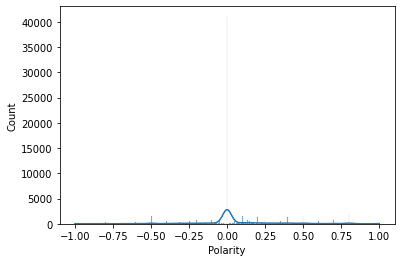

In [ ]:
# Plotting a distribution of polarity of sentiments towards ruto
sns.histplot(data=df_ruto, x="Polarity", kde=True)

# Showing plot
plt.show()


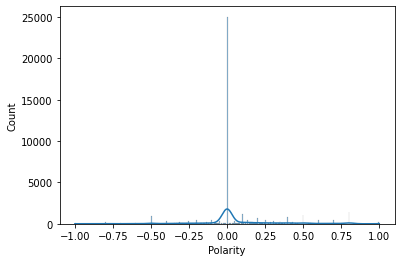

In [ ]:
# Plotting a distribution of polarity of sentiments towards raila
sns.histplot(data=df_raila, x="Polarity", kde=True)

# Showing plot
plt.show()

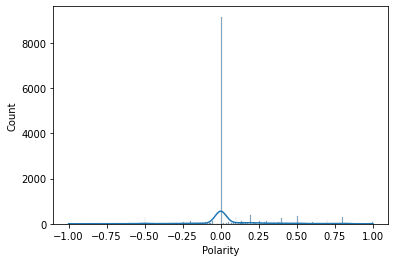

In [ ]:
# Plotting a distribution of sentiments towards wajackhoyah
sns.histplot(data=df_wajackoyah, x="Polarity", kde=True)

# Showing plot
plt.show()

From the visuals of the three presidential aspirants it is evident that most of the sentiments with their mentions are neutral

### Polarity- counts

In [ ]:
# Printing out the number of records that have neutral sentiments in the different presidential datasets
print(df_ruto[df_ruto['Polarity']==0].shape)
print(df_raila[df_raila['Polarity']==0].shape)
print(df_wajackoyah[df_wajackoyah['Polarity']==0].shape)

(40945, 12)
(25019, 12)
(9144, 12)


The dataframe with tweets that mentioned ruto has the most neutral sentiments, while wajackoyah has the least neutral sentiments

In [ ]:
# printing out records with positive sentiments  in the different presidential datasets
print(df_ruto[df_ruto['Polarity']>0].shape)
print(df_raila[df_raila['Polarity']>0].shape)
print(df_wajackoyah[df_wajackoyah['Polarity']>0].shape)

(20164, 12)
(13540, 12)
(3855, 12)


From the result above, Ruto is the presidential aspirant with the most number of positive sentiments by social media users. Wajackoyah has the least number of positive sentiments

In [ ]:
# Printing out number of records with negative sentiments  in the different presidential datasets
print(df_ruto[df_ruto['Polarity']<0].shape)
print(df_raila[df_raila['Polarity']<0].shape)
print(df_wajackoyah[df_wajackoyah['Polarity']<0].shape)

(11240, 12)
(6879, 12)
(1649, 12)


From the result above, Ruto recieves the highest number of negative sentiments among social media users, while wajackhoyah recieves the least number of negative sentiments by social media users

In [ ]:
# creating a dataframe grouing neutral sentiments in the three different presidential datasets
neutral_ruto = df_ruto[df_ruto['Polarity']==0]
neutral_raila = df_raila[df_raila['Polarity']==0]
neutral_wajackoyah = df_wajackoyah[df_wajackoyah['Polarity']==0]

# Getting a average number of neutral sentiments for the three presidential aspirants
total_neutral = (len(neutral_ruto) + len(neutral_raila) + len(neutral_wajackoyah))/3

In [ ]:
# droppping neutral sentiments for all datasets and printing remaining number of records per dataframe
df_ruto.drop((df_ruto[df_ruto['Polarity']==0]).index, inplace=True)
df_raila.drop((df_raila[df_raila['Polarity']==0]).index, inplace=True)
df_wajackoyah.drop((df_wajackoyah[df_wajackoyah['Polarity']==0]).index, inplace=True)


### Polarity- distplots

In [ ]:
# distplot of polarity of sentiments towards ruto after removing neutral sentiments
sns.distplot(df_ruto['Polarity'])

# Show plot
plt.show()

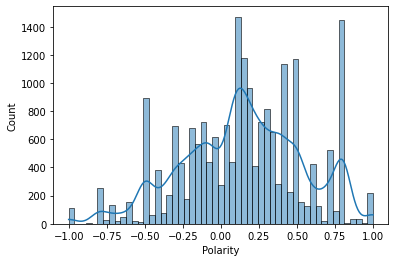

In [ ]:
# distplot of polarity of sentiments towards raila after removing neutral sentiments
sns.histplot(data=df_raila, x="Polarity", kde=True)

# Show plot
plt.show()

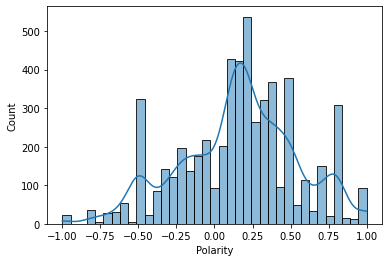

In [ ]:
# distplot of polarity of sentiments towards wajackhoyah after removing neutral sentiments
sns.histplot(data=df_wajackoyah, x="Polarity", kde=True)

# Show plot
plt.show()

From the distplots, it is clear that most social media users have slighty negative or positive sentiments towards the three presidential aspirants

### Polarity boxplots

In [ ]:
# Boxplot of sentiment polarity towards ruto
sns.boxplot(df_ruto['Polarity']);

# Show plot
plt.show()

In [ ]:
# Boxplot of sentiment polarity towards raila
sns.boxplot(df_raila['Polarity']);

# Show plot
plt.show()

In [ ]:
# Boxplot of sentiment polarity towards wajackhoyah
sns.boxplot(df_wajackoyah['Polarity']);

# Show plot
plt.show()

From the boxplots, there are no outliers in positive sentiments towards the various presidential aspirants. However tehre are some social media users that have extremely negative senyiments towards the different presidential aspirants

### Polarity - Group & countby expressions(negative/positive/neutral)

In [ ]:
# grouping to get total positive and negative reviews
df_ruto.groupby('Expressions').count()

Unnamed: 0.1  Unnamed: 0  tweet_id   time  tweet  retweet_count  \
Expressions                                                                    
Negative            11240       11240     11240  11240  11240          11240   
Positive            20164       20164     20164  20164  20164          20164   

             tweet_clean  Subjectivity  Polarity  presidential_aspirant  \
Expressions                                                               
Negative           11240         11240     11240                  11240   
Positive           20164         20164     20164                  20164   

             coalition  
Expressions             
Negative         11240  
Positive         20164

In [ ]:
# grouping to get total positive and negative reviews
df_raila.groupby('Expressions').count()

Unnamed: 0.1  Unnamed: 0  tweet_id   time  tweet  retweet_count  \
Expressions                                                                    
Negative             6879        6879      6879   6879   6879           6879   
Positive            13540       13540     13540  13540  13540          13540   

             tweet_clean  Subjectivity  Polarity  presidential_aspirant  \
Expressions                                                               
Negative            6879          6879      6879                   6879   
Positive           13540         13540     13540                  13540   

             coalition  
Expressions             
Negative          6879  
Positive         13540

In [ ]:
# grouping to get total positive and negative reviews
df_wajackoyah.groupby('Expressions').count()

Unnamed: 0.1  Unnamed: 0  tweet_id  time  tweet  retweet_count  \
Expressions                                                                   
Negative             1649        1649      1649  1649   1649           1649   
Positive             3855        3855      3855  3855   3855           3855   

             tweet_clean  Subjectivity  Polarity  presidential_aspirant  \
Expressions                                                               
Negative            1649          1649      1649                   1649   
Positive            3855          3855      3855                   3855   

             coalition  
Expressions             
Negative          1649  
Positive          3855

### Most positive and negative tweets

In [ ]:
# function returning the tweets that were most positive together with ther polaritys
def pos_tweets(tweets,title):

    most_pos_text = tweets[tweets['Polarity'] == 1].tweet.head()

    most_pos_pol = tweets[tweets['Polarity'] == 1].Polarity.head()

    return most_pos_text, most_pos_pol 

"""    go.Figure(data=[go.Table(columnorder=[1,2],
                             columnwidth=[10,100],
                             header={'values':['Polarity',title],'align':'left'},
                             cells ={'values':[most_pos_pol,most_pos_text],'align':'left'}
                            )]).update_layout(title_text=title).show()"""

"    go.Figure(data=[go.Table(columnorder=[1,2],\n                             columnwidth=[10,100],\n                             header={'values':['Polarity',title],'align':'left'},\n                             cells ={'values':[most_pos_pol,most_pos_text],'align':'left'}\n                            )]).update_layout(title_text=title).show()"

In [ ]:
# most positive tweets for

# Ruto
pos_tweets(df_ruto,'Positive tweets for William Ruto')

# Raila
pos_tweets(df_raila,'Positive tweets for Raila Odinga')

# Wajackhoyah
pos_tweets(df_wajackoyah,'Positive tweets for George wajackoyah')


(190640    @Kenyans @comradefyat Iv never seen a man with...
 190830    If Wajackoyah's Bhangi manifesto can revolutio...
 191871    @OleItumbi @WilliamsRuto The biggest lyer is a...
 192033    @craizyjux Kijana Wajackoyah anakudangaya. Be ...
 192092     @Kenyans Wajackoyah's roots is breathtaking üòäüòä‚òùÔ∏è
 Name: tweet, dtype: object,
 190640    1.0
 190830    1.0
 191871    1.0
 192033    1.0
 192092    1.0
 Name: Polarity, dtype: float64)

In [ ]:
# function returning the tweets that were most negative together with ther polaritys
def neg_tweets(tweets,title):

    most_neg_text = tweets[tweets['Polarity'] == -1].tweet.head()

    most_neg_pol = tweets[tweets['Polarity'] == -1].Polarity.head()

    return most_neg_text, most_neg_pol 

"""    go.Figure(data=[go.Table(columnorder=[1,2],
                             columnwidth=[10,100],
                             header={'values':['Polarity',title],'align':'left'},
                             cells ={'values':[most_pos_pol,most_pos_text],'align':'left'}
                            )]).update_layout(title_text=title).show()"""



"    go.Figure(data=[go.Table(columnorder=[1,2],\n                             columnwidth=[10,100],\n                             header={'values':['Polarity',title],'align':'left'},\n                             cells ={'values':[most_pos_pol,most_pos_text],'align':'left'}\n                            )]).update_layout(title_text=title).show()"

In [ ]:
# most negative tweets for

# Ruto
neg_tweets(df_ruto,'negative tweets for William Ruto')

# Raila
neg_tweets(df_raila,'negative tweets for Raila Odinga')

# Wajackhoyah
neg_tweets(df_wajackoyah,'negative tweets for George wajackoyah')


(190724    At least the Union of veterinary practitioners...
 190781    People have been called worst, my locs for Waj...
 190977    @MigunaMiguna @betty_belkola Man you're are be...
 192920                  Wajackoyah is not completely insane
 193626    @IkeOjuok @Politricks_101 Wajackoyah is a terr...
 Name: tweet, dtype: object,
 190724   -1.0
 190781   -1.0
 190977   -1.0
 192920   -1.0
 193626   -1.0
 Name: Polarity, dtype: float64)

In [ ]:
# function genrating word cloud showing the most popular words for different presidential aspirants
def wordcloud(data,title):
    text = str(data.tweet_clean)
    wc = WordCloud(max_font_size=100,max_words=500,scale=10,relative_scaling=0.6,background_color='white').generate(text)

    plt.figure(figsize=(15,10))
    plt.title(title,{'fontsize':30,'family':'serif'})
    plt.axis('off')
    plt.imshow(wc)

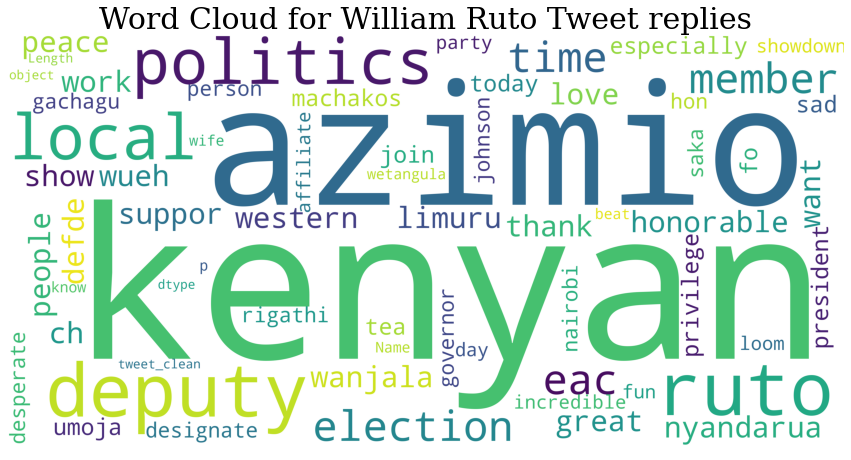

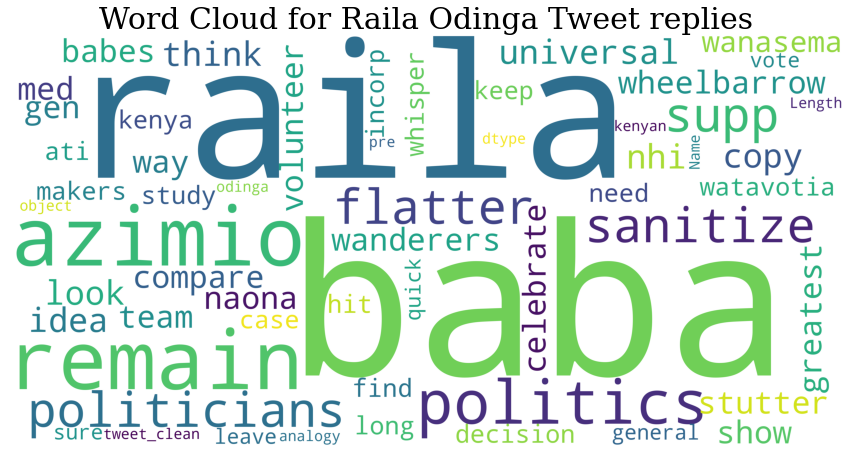

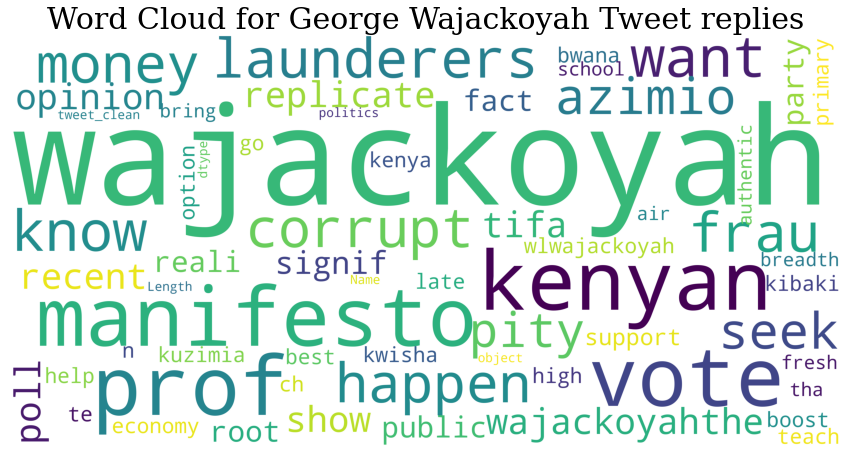

In [ ]:
wordcloud(df_ruto, 'Word Cloud for William Ruto Tweet replies')

wordcloud(df_raila, 'Word Cloud for Raila Odinga Tweet replies')

wordcloud(df_wajackoyah, 'Word Cloud for George Wajackoyah Tweet replies')


### Bivariate analysis

In [ ]:
# function get percentage of negative and positive sentiments
def pol_percent(subset,total):
    neg_percent = ((subset.groupby('Expressions').count())['Polarity'][0]/total)*100
    pos_percent = ((subset.groupby('Expressions').count())['Polarity'][1]/total)*100
    
    return neg_percent,pos_percent

In [ ]:
# get thee length of the various dataframe subsets
records_raila = len(df_raila)
records_ruto = len(df_ruto)
records_wajackoyah = len(df_wajackoyah)

# Sumtotal of all positive, neutral and negative records for the three presidential aspirants
total_records = records_raila + records_ruto + records_wajackoyah + total_neutral

In [ ]:
# getting percentage of negative and positive sentiments for the three different presidential aspirants

# Ruto
ruto_pol_percent = pol_percent(df_ruto,records_ruto)
print(ruto_pol_percent)

# Raila
raila_pol_percent = pol_percent(df_raila,records_raila)
print(raila_pol_percent)

# Raila
wajackoyah_pol_percent = pol_percent(df_wajackoyah,records_wajackoyah)
print(wajackoyah_pol_percent)

(35.79161890205069, 64.20838109794931)
(33.68921102894363, 66.31078897105637)
(29.96002906976744, 70.03997093023256)


In [ ]:
# Plotting the distribution of positive and negative tweets per presidential candidate

# list of presidential aspirants
candidate = ['Dr. William Samoei Ruto','Raila Amollo Odinga', 'Prof. George Luchiri Wajackoyah']

# List of percentage positive and negative sentiments
pos = [ruto_pol_percent[1], raila_pol_percent[1], wajackoyah_pol_percent[1]]
neg = [ruto_pol_percent[0], raila_pol_percent[0], wajackoyah_pol_percent[0]] 

# plot
go.Figure(data=[
    go.Bar(name = 'Positive', x=candidate, y=pos),
    go.Bar(name = 'Negative', x=candidate, y=neg),   
])

## Presidential prediction

In [ ]:
# get the favour per presidential aspirant and undecided social media users

# Ruto's favour
ruto_pos = (ruto_pol_percent[1] + (raila_pol_percent[0] + wajackoyah_pol_percent[0])/2) * (records_ruto/total_records )
print(ruto_pos)

# Raila's favour
raila_pos = (raila_pol_percent[1] + (ruto_pol_percent[0] + wajackoyah_pol_percent[0])/2) * (records_raila/total_records )
print(raila_pos)

# Wajackhoyah's favour
wajackoyah_pos = (wajackoyah_pol_percent[1] + (ruto_pol_percent[0] + raila_pol_percent[0])/2) * (records_wajackoyah/total_records)
print(wajackoyah_pos)

# Undecided social media users
undecided_pos = (total_neutral/total_records) * 100
print(undecided_pos)

36.61620348979471
24.589821278587195
7.002066995739549
30.397144348797394


In [ ]:
# Creating a dataframe of the presidential outcomes and presidential prediction

# List of presidential aspirants and class of undecided electorate
y = ['ruto\'s Favour' ,'raila\'s Favour','wajackoyah\'s Favour', 'undecided voters']

# List of the three presidential aspirants plus class of undecided electorate
x = [ruto_pos,raila_pos, wajackoyah_pos, undecided_pos]

# dataframe of the elective class and labels of these claases
poll_prediction = pd.DataFrame(list(zip(y, x)),
               columns =['name', 'val'])

In [ ]:
# Sorting the values of the presidential prediction in ascending order
fd = poll_prediction.sort_values(by='val', ascending = True)

# Running data in go bar
my_data = [go.Bar( x = fd.name, y = fd.val, orientation = 'h')]

# plot favour per presidentail aspirant
go.Figure(go.Bar(y=fd.name,
                 x= fd.val,
                 marker={'color':['rgb(100,200,150)','rgb(90,150,200)']},
                 orientation='h')).update_layout(title_text='Public Opinion')

In [ ]:
# Getting total records of voters ignoring neutral tweets since in general election 
# there is no section of undecided in a ballot paper to predict the most likely 
# outcome of the 2022 elections
total_outcome = total_records - total_neutral

In [ ]:
# get the favour per presidential aspirant and undecided social media users

# Ruto's favour
ruto_pos = (ruto_pol_percent[1] + (raila_pol_percent[0] + wajackoyah_pol_percent[0])/2) * (records_ruto/total_outcome )
print(ruto_pos)

# Raila's favour
raila_pos = (raila_pol_percent[1] + (ruto_pol_percent[0] + wajackoyah_pol_percent[0])/2) * (records_raila/total_outcome )
print(raila_pos)

# Wajackhoyah's favour
wajackoyah_pos = (wajackoyah_pol_percent[1] + (ruto_pol_percent[0] + raila_pol_percent[0])/2) * (records_wajackoyah/total_outcome)
print(wajackoyah_pos)


52.607329321784874
35.32875346639938
10.060028328189098


In [ ]:
# Creating a dataframe of the presidential outcomes and presidential prediction

# List of presidential aspirants and class of undecided electorate
y = ['ruto\'s Favour' ,'raila\'s Favour','wajackoyah\'s Favour']

# List of the three presidential aspirants plus class of undecided electorate
x = [ruto_pos,raila_pos, wajackoyah_pos]

# dataframe of the elective class and labels of these claases
poll_prediction = pd.DataFrame(list(zip(y, x)),
               columns =['name', 'val'])

In [ ]:
# Sorting the values of the presidential prediction in ascending order
fd = poll_prediction.sort_values(by='val', ascending = True)

# Running data in go bar
my_data = [go.Bar( x = fd.name, y = fd.val, orientation = 'h')]

# plot favour per presidentail aspirant
go.Figure(go.Bar(y=fd.name,
                 x= fd.val,
                 marker={'color':['rgb(100,200,150)','rgb(90,150,200)']},
                 orientation='h')).update_layout(title_text='Public Opinion')

## Results

**General sentiments**

The top ten most mentioned topics by social media users was as follows;

        bigram	    count	
0	kenya kwanza	    1640.103117	
1	raila odinga	    1458.472561	
2	william ruto	    1169.901490	
3	root party	      734.132224	
4	deputy president	510.946974	
5	party manifesto	  438.900758	
6	martha karua	    432.610101
7	vote ruto	        378.414608
8	president kenya	  369.138789	
9	ruto president	  361.117241



**Political coalitions**

The popularity of the various coalitions in this elections is as follows;
  coalition	count
1	Kenya Kwanza	67.237060
2	Roots Party	21.375510
3	azimio OKA alliance	11.387431 

Kenya kwanza leads the way with over three times the mentiosnof it's nearest competitor Roots party



**Presidential Aspirants**

From the analysis, The presidential aspirant william Ruto seemed to have the highest swings in terms of polarity. Ruto had the most positive and the most negative sentiments directed towards him by the various social media users of any of the three presidential aspirants

Raila Odinga was second of the three presidential aspirants in all categories while Wajackhoyah tailed in all these three respects

In terms of mentions, the popularity is as follows;

	  presidential_aspirant	        count
1	Dr. William Samoei Ruto	        56.793755
2	Raila Amollo Odinga	            39.664946
3	Prof. George Luchiri Wajackoyah	3.541299

Ruto was the most mentioned presidential aspirant



**Election prediction**

*With undecided voters*

By assuming that the positive sentiments a presidential aspirant gets equats to support and the negative sentiments gets equates to support of the opponnent, and this favour is affected by the occurence of that presidential aspirant in the dataset, the following results were obtained;

Dr. William Ruto = 36.61620348979471
Undecided Voters = 30.397144348797394
Raila Amollo Odinga = 24.589821278587195
Prof George Wajackoyah = 7.002066995739549

From our analysis Ruto leads the pack followed by the undecided voters while Wajackhoyah tails the pack

*Excluding undecided voters*

Excluding the undecided voters, the following results were obtained

Dr. William Ruto = 52.607329321784874
Raila Amollo Odinga = 35.32875346639938
Prof George Wajackoyah = 10.060028328189098



## Conclusion

From the list of the top 10 most trending topics, it was concluded that Kenyas politics is not issue rather personality based since 9/10 of the top mentions were politicians/political parties

From our analysis, we concluded that William Ruto is the most polarizing candidate. Ruto has the highest number of positive sentiments at the same time the highest number of negative sentiments

We also concluded that Ruto is the most mentioned political figure in the country while Wajackhoyah is the least mentioned

From our election prediction results, factoring in neutral voters as undecided voters, it was concluded that a large part of the electorate is still undecided on who to vote for in the forth coming election. 

Without the undecided voters, from the analysis, it was concluded that William Ruto will most likely win the election in the first round with slightly over 50% of the votes. 

**Disclaimer**

This prediction is made using only sentiments sourced from social media hence is not fully representative of Kenya's electorate

## Further questions

### A) Do we have the right question?

Yes we do

### B) Do we have the right data?

Yes the data is sufficient, upto date and appropiate to meet our objectives